# Model-Assisted Labeling (MAL) Workflow with DeepLab & CVAT (Later ML Paint for comparison)

This notebook provides an end-to-end MAL pipeline:

1. **Tile Split**: Break large GeoTIFF images into 512×512 tiles
2. **Prediction**: Generate masks using trained DeepLab model
3. **Visualization**: Preview predictions before CVAT annotation
4. **CVAT Refinement**: Manual annotation/correction (in web UI, not here)
5. **Reconstruction**: Stitch corrected masks back into full GeoTIFF

**Workflow**: Phase 1 → Phase 2 → Phase 3 → (CVAT in browser) → Phase 5

# Installing CVAT on Windows

## Step 1: Install Git for Windows

1. Download Git for Windows from [https://gitforwindows.org/](https://gitforwindows.org/).
2. Install Git, keeping all options as default.
3. Open the command prompt (`cmd`) and type the following command to check the Git version:
    ```bash
    git --version
    ```

## Step 2: Install Docker Desktop for Windows

1. Download [Docker Desktop for Windows](https://desktop.docker.com/win/main/amd64/Docker%20Desktop%20Installer.exe).
2. Double-click the Docker for Windows Installer to run the installer.
3. Follow the instructions for installation, and reboot the system after installation is complete.
4. Open the command prompt and check the Docker version:
    ```bash
    docker --version
    ```
5. Check the Docker Compose version:
    ```bash
    docker compose version
    ```

## Step 3: Install Google Chrome

1. Download and install [Google Chrome](https://www.google.com/chrome/), as it is the only browser supported by CVAT.

## Step 4: Clone CVAT Source Code

1. Clone CVAT source code from the [GitHub repository](https://github.com/opencv/cvat):
    ```bash
    git clone https://github.com/opencv/cvat
    cd cvat
    ```
2. Alternatively, check [alternatives](https://opencv.github.io/cvat/docs/administration/basics/installation/#how-to-get-cvat-source-code) for downloading specific release versions.

## Step 5: Run Docker Containers for CVAT

1. Run the following command to start Docker containers. This will download the latest CVAT release and other required images:
    ```bash
    docker compose up -d
    ```
2. Optionally, specify the CVAT version using the CVAT_VERSION environment variable:
    ```bash
    CVAT_VERSION=dev docker compose up -d
    ```
3. Check the status of the containers:
    ```bash
    docker ps
    ```
4. Wait until the CVAT server is up and running:
    ```bash
    docker logs cvat_server -f
    ```
5. Run the CVAT server:
    ```bash
    docker exec -it cvat_server bash
    ```
6. For the first-time setup, create a superuser account:
    ```bash
    python3 manage.py createsuperuser
    ```
    Choose a username and password for the admin account.

## Step 6: Access CVAT in Google Chrome

1. Open Google Chrome and go to `localhost:8080`.
2. Log in with the superuser credentials created earlier.
3. You should now be able to create a new annotation task.

## Workflow
To stop and remove the container, simply type, 
```bash
docker compose down
```
And to start cvat again, simply type 
```bash
docker compose up -d
```
Make sure you're in the correct directory

In [99]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import shutil
from typing import Dict, List

# Add project to path
sys.path.insert(0, '../../')
from models import DeepLab

# Check GPU
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}\n")

# Configuration
CLASS_NAMES = ['background', 'building', 'woodland', 'water', 'road']
NUM_CLASSES = len(CLASS_NAMES)
TILE_SIZE = 512

# Define workspace directories
WORKSPACE_DIR = Path("mal_workspace")
TILES_DIR = WORKSPACE_DIR / "01_tiles"
PREDICTIONS_DIR = WORKSPACE_DIR / "02_predictions"
CORRECTED_MASKS_DIR = WORKSPACE_DIR / "02_predictions"
RECONSTRUCTED_DIR = WORKSPACE_DIR / "04_reconstructed"

print(f"✓ Setup complete | Device: {device}")

PyTorch: 2.4.1+cu124
CUDA available: True
Device: NVIDIA GeForce RTX 4060
Memory: 8.0 GB
Using device: cuda

✓ Setup complete | Device: cuda


In [100]:
# ===== UPDATE THESE PATHS =====
INPUT_GEOTIFF = "cvat_test/images/M-33-7-A-d-2-3.tif"  # Change this path as needed
CHECKPOINT_PATH = "experiments/Deeplab_Landcover_Edited/best_model.pth"  # Change this to your model
# ==============================

# Verify files exist
if not Path(INPUT_GEOTIFF).exists():
    print(f"⚠️  WARNING: {INPUT_GEOTIFF} not found!")
else:
    print(f"✓ Input GeoTIFF: {INPUT_GEOTIFF}")

if not Path(CHECKPOINT_PATH).exists():
    print(f"⚠️  WARNING: {CHECKPOINT_PATH} not found!")
else:
    print(f"✓ Checkpoint: {CHECKPOINT_PATH}")

print(f"\nWorkspace: {WORKSPACE_DIR}")
print(f"Classes: {CLASS_NAMES}")

✓ Input GeoTIFF: cvat_test/images/M-33-7-A-d-2-3.tif
✓ Checkpoint: experiments/Deeplab_Landcover_Edited/best_model.pth

Workspace: mal_workspace
Classes: ['background', 'building', 'woodland', 'water', 'road']


In [101]:
def tile_geotiff(input_path: str, output_dir: str, tile_size: int = 512, overlap: int = 0) -> Dict:
    """
    Break a large GeoTIFF into non-overlapping or overlapping tiles.
    
    Args:
        input_path: Path to input GeoTIFF
        output_dir: Directory to save tiles
        tile_size: Tile size (default 512)
        overlap: Overlap in pixels between tiles (default 0)
    
    Returns:
        Metadata dict with tile info and original shape
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Load image
    img = Image.open(input_path)
    img_array = np.array(img)
    height, width = img_array.shape[:2]
    
    print(f"Tiling {Path(input_path).name}")
    print(f"  Original shape: {img_array.shape}")
    print(f"  Tile size: {tile_size}×{tile_size}, Overlap: {overlap}px")
    
    tiles_metadata = []
    stride = tile_size - overlap
    
    # Extract tiles
    for y in range(0, height - tile_size + 1, stride):
        for x in range(0, width - tile_size + 1, stride):
            tile = img_array[y:y+tile_size, x:x+tile_size]
            
            if tile.shape[0] != tile_size or tile.shape[1] != tile_size:
                continue
            
            tile_name = f"tile_{y:05d}_{x:05d}"
            tile_path = Path(output_dir) / f"{tile_name}.png"
            
            Image.fromarray(tile.astype(np.uint8)).save(tile_path)
            
            tiles_metadata.append({
                "tile_id": tile_name,
                "filename": f"{tile_name}.png",
                "original_x": int(x),
                "original_y": int(y),
                "width": tile_size,
                "height": tile_size
            })
    
    metadata = {
        "original_shape": list(img_array.shape),
        "tile_size": tile_size,
        "tile_count": len(tiles_metadata),
        "tiles": tiles_metadata
    }
    
    print(f"✓ Created {len(tiles_metadata)} tiles\n")
    return metadata

print("✓ Tiling function loaded")

✓ Tiling function loaded


In [102]:
def load_model(checkpoint_path: str) -> DeepLab:
    """Load trained DeepLab model."""
    model = DeepLab(
        num_classes=NUM_CLASSES,
        input_image_size=TILE_SIZE,
        backbone='resnet50',
        output_stride=4
    ).to(device)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    if isinstance(checkpoint, dict) and 'model' in checkpoint:
        model.load_state_dict(checkpoint['model'])
    else:
        model.load_state_dict(checkpoint)
    
    model.eval()
    
    # Ensure all dropout and batch norm layers are in eval mode
    for module in model.modules():
        if isinstance(module, (nn.Dropout, nn.BatchNorm2d)):
            module.eval()
    
    print(f"✓ Model loaded from {Path(checkpoint_path).name}\n")
    return model


def normalize_image(image: np.ndarray) -> torch.Tensor:
    """Normalize image to [-2, 2] range using ImageNet stats."""
    image = image.astype(np.float32) / 255.0
    image = torch.from_numpy(image).permute(2, 0, 1)
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = (image - mean) / std
    
    return image


def predict_single_tile(model: DeepLab, image_path: str, debug: bool = False) -> np.ndarray:
    """Generate prediction mask for one tile."""
    image = np.array(Image.open(image_path).convert('RGB'))
    image_tensor = normalize_image(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        
        if debug:
            print(f"Output shape: {output.shape}")
            print(f"Output min/max: {output.min():.4f} / {output.max():.4f}")
            print(f"Class logits sample (center pixel): {output[0, :, 256, 256]}")
        
        mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
        if debug:
            print(f"Mask unique classes: {np.unique(mask)}\n")
    
    return mask.astype(np.uint8)


def generate_all_predictions(model: DeepLab, tiles_dir: str, output_dir: str) -> List[str]:
    """Generate predictions for all tiles in a directory."""
    os.makedirs(output_dir, exist_ok=True)
    
    tile_files = sorted([f for f in os.listdir(tiles_dir) if f.endswith('.png')])
    print(f"Generating predictions for {len(tile_files)} tiles...")
    
    # Test first tile with debug info
    if tile_files:
        first_tile = Path(tiles_dir) / tile_files[0]
        print(f"\n🔍 Testing first tile: {tile_files[0]}")
        test_mask = predict_single_tile(model, str(first_tile), debug=True)
    
    prediction_paths = []
    for tile_file in tqdm(tile_files, desc="Predicting"):
        tile_path = Path(tiles_dir) / tile_file
        pred_mask = predict_single_tile(model, str(tile_path))
        
        pred_name = tile_file.replace('.png', '_pred.png')
        pred_path = Path(output_dir) / pred_name
        
        Image.fromarray(pred_mask).save(pred_path)
        prediction_paths.append(pred_path)
    
    print(f"✓ Generated {len(prediction_paths)} predictions\n")
    return prediction_paths

print("✓ Inference functions loaded")

✓ Inference functions loaded


In [103]:
def visualize_predictions(tiles_dir: str, predictions_dir: str, num_samples: int = 4):
    """
    Display sample tiles with predictions.
    
    Shows: Original Image | Predicted Mask | Overlay
    """
    tile_files = sorted([f for f in os.listdir(tiles_dir) if f.endswith('.png')])
    indices = np.random.choice(len(tile_files), min(num_samples, len(tile_files)), replace=False)
    
    class_colors = {
        0: [0.0, 0.0, 0.0],       # background - black
        1: [1.0, 0.0, 0.0],       # building - red
        2: [0.0, 0.5, 0.0],       # woodland - green
        3: [0.0, 0.0, 1.0],       # water - blue
        4: [1.0, 1.0, 0.0],       # road - yellow
    }
    
    fig, axes = plt.subplots(len(indices), 3, figsize=(14, 4*len(indices)))
    fig.suptitle('Sample Predictions (Image | Mask | Overlay)', fontsize=14, fontweight='bold')
    
    for row, idx in enumerate(indices):
        tile_file = tile_files[idx]
        tile_path = Path(tiles_dir) / tile_file
        pred_file = tile_file.replace('.png', '_pred.png')
        pred_path = Path(predictions_dir) / pred_file
        
        image = np.array(Image.open(tile_path))
        pred_mask = np.array(Image.open(pred_path))
        
        # Column 1: Image
        axes[row, 0].imshow(image)
        axes[row, 0].set_title(f'Image', fontsize=10)
        axes[row, 0].axis('off')
        
        # Column 2: Mask
        axes[row, 1].imshow(pred_mask, cmap='tab10', vmin=0, vmax=4)
        axes[row, 1].set_title(f'Mask (classes: {np.unique(pred_mask)})', fontsize=10)
        axes[row, 1].axis('off')
        
        # Column 3: Overlay
        mask_rgb = np.zeros((*pred_mask.shape, 3))
        for class_id, color in class_colors.items():
            mask_rgb[pred_mask == class_id] = color
        overlay = 0.65 * (image / 255.0) + 0.35 * mask_rgb
        axes[row, 2].imshow(overlay)
        axes[row, 2].set_title('Overlay', fontsize=10)
        axes[row, 2].axis('off')
    
    plt.tight_layout()
    return fig


In [104]:
def reconstruct_geotiff(tiles_metadata: Dict, corrected_masks_dir: str, output_path: str):
    """
    Stitch corrected tile masks back into a single GeoTIFF.
    
    Args:
        tiles_metadata: Output from tile_geotiff() function
        corrected_masks_dir: Directory containing corrected masks from CVAT
        output_path: Path to save final GeoTIFF
    """
    original_shape = tiles_metadata['original_shape']
    tile_size = tiles_metadata['tile_size']
    
    output_mask = np.zeros(original_shape[:2], dtype=np.uint8)
    
    print(f"Reconstructing GeoTIFF...")
    print(f"  Output shape: {output_mask.shape}")
    print(f"  Processing {len(tiles_metadata['tiles'])} tiles...")
    
    found_count = 0
    for tile_info in tqdm(tiles_metadata['tiles'], desc="Stitching"):
        tile_id = tile_info['tile_id']
        x = tile_info['original_x']
        y = tile_info['original_y']
        
        # Try multiple filename formats (CVAT may export differently)
        candidates = [
            f"{tile_id}_pred.png",
            f"{tile_id}.png",
            Path(corrected_masks_dir) / f"{tile_id}_pred.png",
            Path(corrected_masks_dir) / f"{tile_id}.png"
        ]
        
        mask_path = None
        for candidate in candidates:
            if isinstance(candidate, str):
                candidate = Path(corrected_masks_dir) / candidate
            if candidate.exists():
                mask_path = candidate
                break
        
        if mask_path is None:
            print(f"  ⚠️  Could not find mask for {tile_id}")
            continue
        
        mask = np.array(Image.open(mask_path))
        
        # Handle multi-channel masks
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        
        output_mask[y:y+tile_size, x:x+tile_size] = mask
        found_count += 1
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    Image.fromarray(output_mask).save(output_path)
    
    print(f"✓ Reconstructed GeoTIFF saved")
    print(f"  Output: {output_path}")
    print(f"  Tiles found: {found_count}/{len(tiles_metadata['tiles'])}")
    print(f"  Classes: {np.unique(output_mask)}\n")

print("✓ Helper functions loaded")

✓ Helper functions loaded


In [105]:
def create_cvat_segmentation_mask_export(
    predictions_dir: str,
    output_zip: str,
    class_names: List[str],
    class_colors: Dict[int, tuple] = None
):
    """
    Create a CVAT-compatible Segmentation Mask ZIP file for importing predictions.

    Args:
        predictions_dir: Directory with prediction masks (*_pred.png files)
        output_zip: Path to save the ZIP file (e.g., "mal_workspace/cvat_export.zip")
        class_names: List of class names (e.g., ['background', 'building', 'woodland', 'water', 'road'])
        class_colors: Dict mapping class_id to RGB tuple for labelmap.txt
                     If None, uses default Pascal VOC colors

    Creates this ZIP structure (Required by CVAT. More details check documentation https://docs.cvat.ai/docs/dataset_management/formats/):
        archive.zip/
        ├── labelmap.txt
        ├── ImageSets/Segmentation/default.txt
        ├── SegmentationClass/
        │   ├── tile_00000_00000.png
        │   ├── tile_00000_00512.png
        │   └── ...
        └── SegmentationObject/
            ├── tile_00000_00000.png
            ├── tile_00000_00512.png
            └── ...
    """
    import zipfile
    import tempfile

    # Default Pascal VOC colors if not provided
    if class_colors is None:
        class_colors = {
            0: (0, 0, 0),           # background - black
            1: (128, 0, 0),         # building - maroon
            2: (0, 128, 0),         # woodland - dark green
            3: (0, 0, 128),         # water - navy blue
            4: (128, 128, 0),       # road - olive
        }

    # Create temporary directory for ZIP contents
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_path = Path(temp_dir)

        # Create directory structure
        segmentation_class_dir = temp_path / "SegmentationClass"
        segmentation_object_dir = temp_path / "SegmentationObject"
        imageset_dir = temp_path / "ImageSets" / "Segmentation"

        segmentation_class_dir.mkdir(parents=True, exist_ok=True)
        segmentation_object_dir.mkdir(parents=True, exist_ok=True)
        imageset_dir.mkdir(parents=True, exist_ok=True)

        # ===== CREATE labelmap.txt =====
        labelmap_path = temp_path / "labelmap.txt"
        with open(labelmap_path, 'w') as f:
            for class_id, class_name in enumerate(class_names):
                color = class_colors.get(class_id, (0, 0, 0))
                f.write(f"{class_name}:{color[0]},{color[1]},{color[2]}::\n")

        print(f"Created labelmap.txt with {len(class_names)} classes")

        # ===== GET PREDICTION FILES =====
        pred_files = sorted([f for f in os.listdir(predictions_dir) if f.endswith('.png')])
        image_names = []

        print(f"Processing {len(pred_files)} prediction masks...")

        # ===== COPY MASKS TO BOTH DIRECTORIES =====
        for pred_file in tqdm(pred_files, desc="Copying masks"):
            pred_path = Path(predictions_dir) / pred_file

            # Extract base name (remove '_pred.png' or '.png')
            if pred_file.endswith('_pred.png'):
                base_name = pred_file.replace('_pred.png', '')
            else:
                base_name = pred_file.replace('.png', '')
            
            image_names.append(base_name)

            # Load mask
            mask = np.array(Image.open(pred_path))
            
            # For semantic segmentation, both directories get the same mask
            # (SegmentationClass = class per pixel, SegmentationObject = same for semantic)
            Image.fromarray(mask).save(segmentation_class_dir / f"{base_name}.png")
            Image.fromarray(mask).save(segmentation_object_dir / f"{base_name}.png")

        # ===== CREATE ImageSets/Segmentation/default.txt =====
        default_txt = imageset_dir / "default.txt"
        with open(default_txt, 'w') as f:
            for name in image_names:
                f.write(name + '\n')

        print(f"Created ImageSets/Segmentation/default.txt with {len(image_names)} entries")

        # ===== CREATE ZIP ARCHIVE =====
        os.makedirs(os.path.dirname(output_zip), exist_ok=True)
        
        with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Add all files from temp directory to ZIP
            for root, dirs, files in os.walk(temp_path):
                for file in files:
                    file_path = Path(root) / file
                    # Get relative path from temp_path for ZIP archive
                    arcname = file_path.relative_to(temp_path)
                    zipf.write(file_path, arcname)

        # Print results
        zip_size_mb = Path(output_zip).stat().st_size / (1024**2)
        print(f"\n✓ CVAT Segmentation Mask export created successfully!")
        print(f"  Output ZIP: {output_zip}")
        print(f"  Size: {zip_size_mb:.1f} MB")
        print(f"  Classes: {len(class_names)}")
        print(f"  Masks: {len(image_names)}")

print("✓ CVAT export function loaded")

✓ CVAT export function loaded


In [106]:
print("=" * 60)
print("PHASE 1: TILE SPLITTING")
print("=" * 60)

# Create tiles
tiles_metadata = tile_geotiff(
    input_path=INPUT_GEOTIFF,
    output_dir=str(TILES_DIR),
    tile_size=TILE_SIZE,
    overlap=0  # Change to 64 for 64px overlap if desired. We using 0 overlapping for now
)

# Save metadata for later use
metadata_path = WORKSPACE_DIR / "tiles_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(tiles_metadata, f, indent=2)

print(f"Metadata saved: {metadata_path}")


PHASE 1: TILE SPLITTING
Tiling M-33-7-A-d-2-3.tif
  Original shape: (9711, 9081, 3)
  Tile size: 512×512, Overlap: 0px
✓ Created 306 tiles

Metadata saved: mal_workspace\tiles_metadata.json


In [107]:
print("=" * 60)
print("PHASE 2: GENERATE PREDICTIONS")
print("=" * 60)

# Load model
model = load_model(CHECKPOINT_PATH)

# Generate predictions
prediction_paths = generate_all_predictions(
    model=model,
    tiles_dir=str(TILES_DIR),
    output_dir=str(PREDICTIONS_DIR)
)

PHASE 2: GENERATE PREDICTIONS


C:\Users\adytc\AppData\Local\Temp\ipykernel_38592\2567624637.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

✓ Model loaded from best_model.pth

Generating predictions for 306 tiles...

🔍 Testing first tile: tile_00000_00000.png
Output shape: torch.Size([1, 5, 512, 512])
Output min/max: -1.7467 / 1.3903
Class logits sample (center pixel): tensor([-0.3692,  1.1136,  1.3427, -1.6940,  0.6736], device='cuda:0')
Mask unique classes: [0 2]



Predicting: 100%|██████████| 306/306 [00:38<00:00,  8.00it/s]

✓ Generated 306 predictions



In [108]:
# Create CVAT-compatible export
create_cvat_segmentation_mask_export(
    predictions_dir=str(PREDICTIONS_DIR),
    output_zip="mal_workspace/cvat_predictions_export.zip",
    class_names=CLASS_NAMES,
    class_colors={
        0: (0, 0, 0),         # background - black
        1: (128, 0, 0),       # building - maroon
        2: (0, 128, 0),       # woodland - dark green
        3: (0, 0, 128),       # water - navy blue
        4: (128, 128, 0),     # road - olive
    }
)

Created labelmap.txt with 5 classes
Processing 306 prediction masks...


Copying masks: 100%|██████████| 306/306 [00:02<00:00, 143.16it/s]


Created ImageSets/Segmentation/default.txt with 306 entries

✓ CVAT Segmentation Mask export created successfully!
  Output ZIP: mal_workspace/cvat_predictions_export.zip
  Size: 0.8 MB
  Classes: 5
  Masks: 306


PHASE 3: VISUALIZE PREDICTIONS


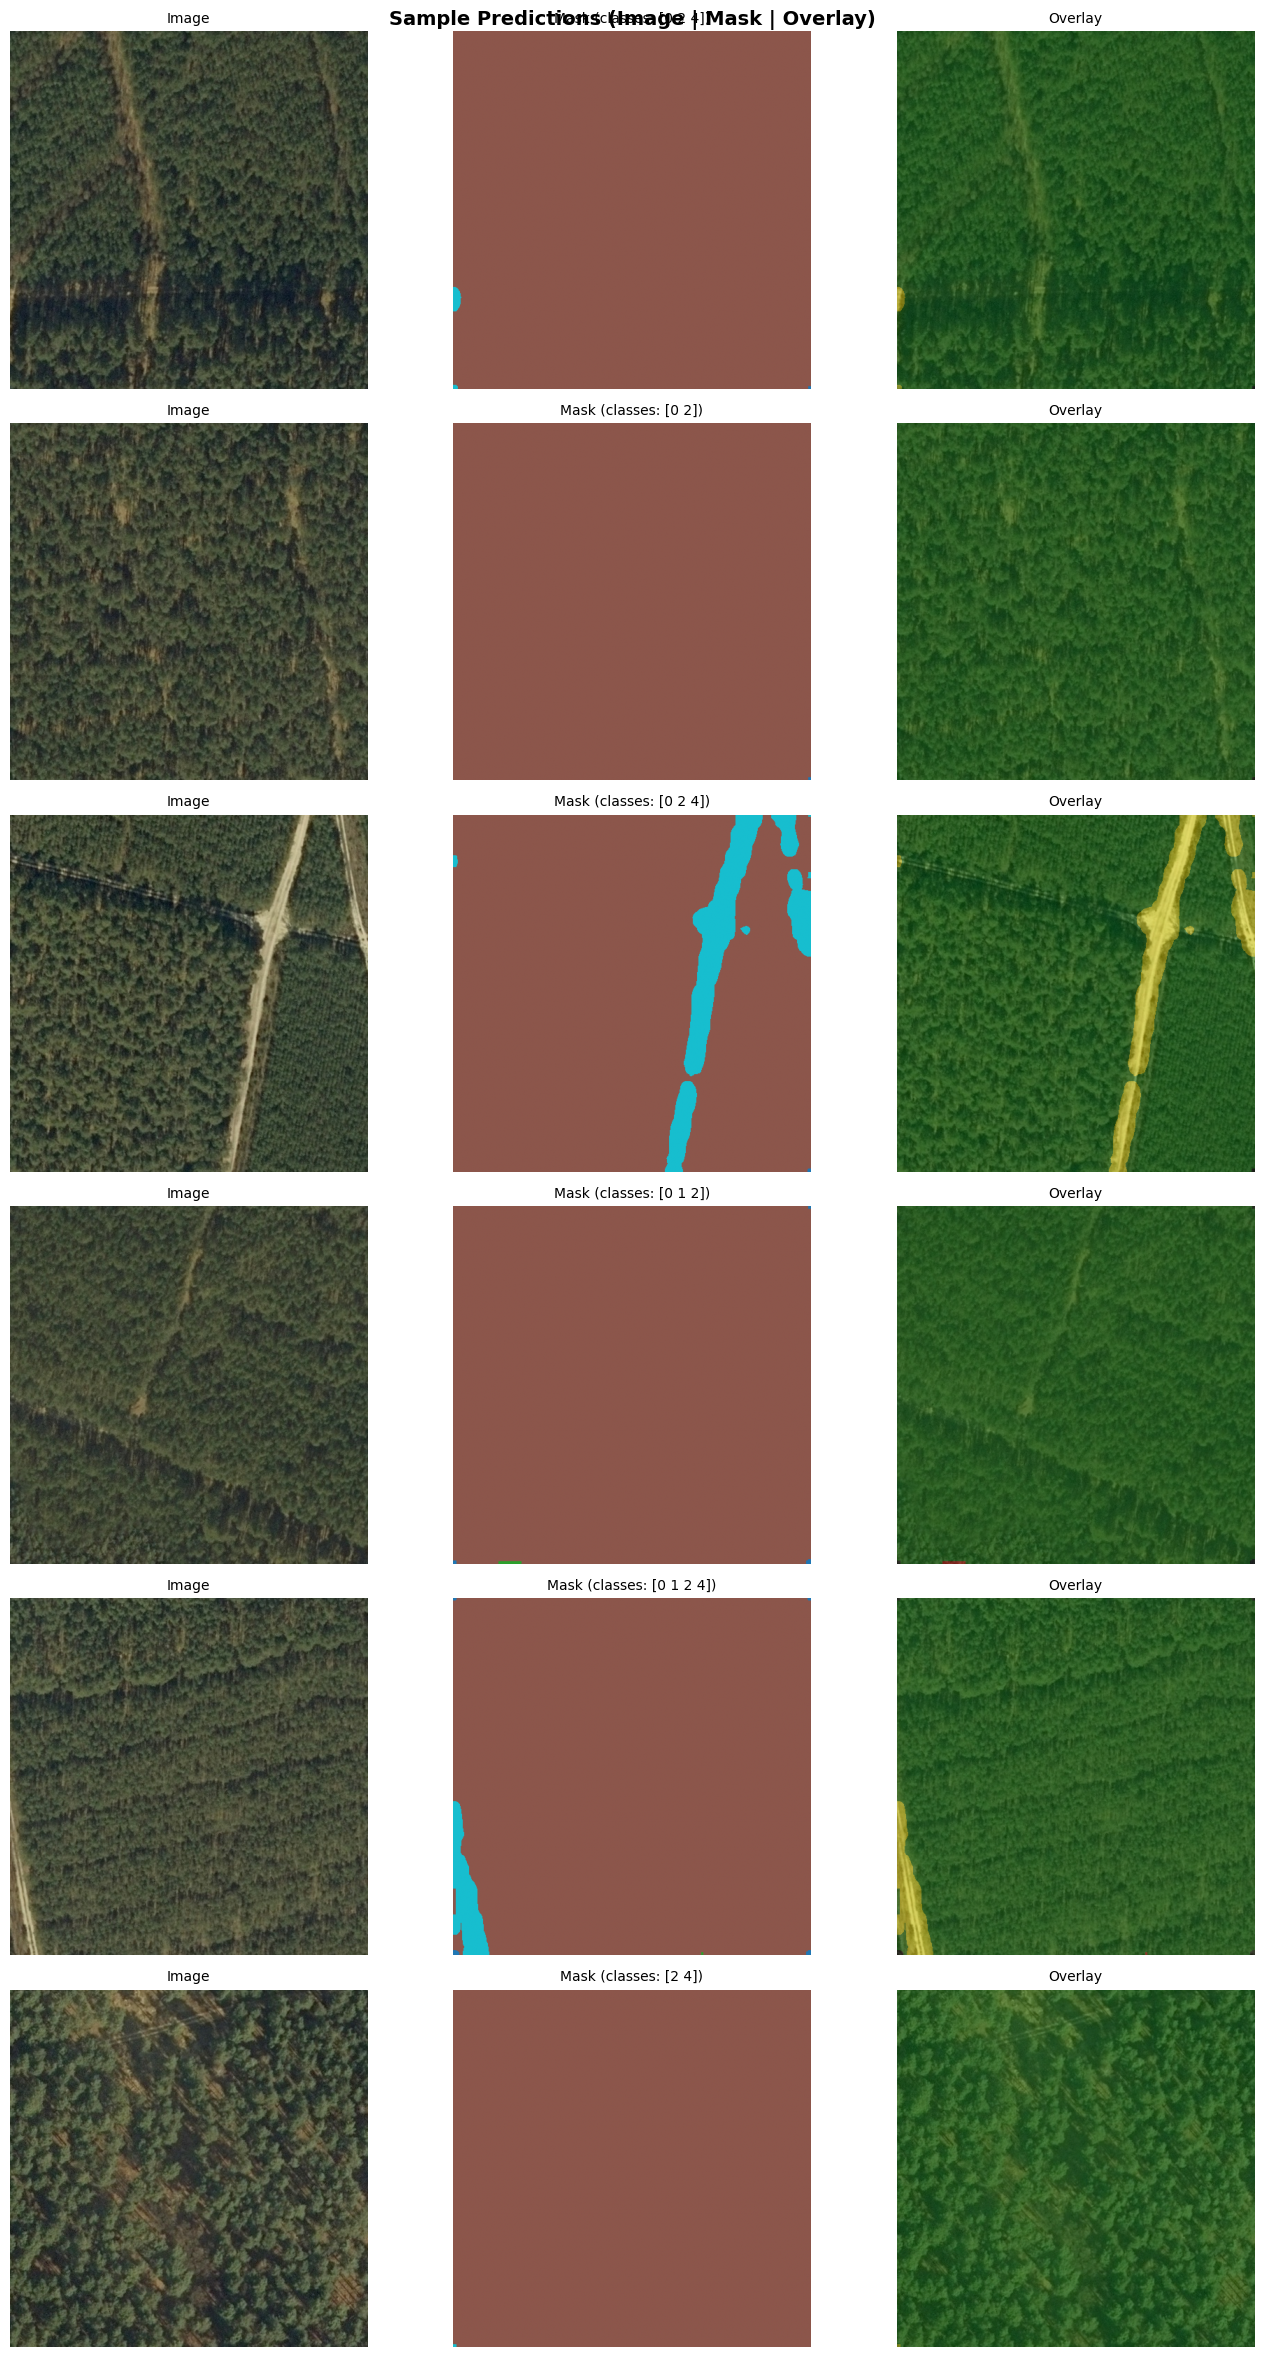

Preview saved: mal_workspace\predictions_preview.png


In [109]:
print("=" * 60)
print("PHASE 3: VISUALIZE PREDICTIONS")
print("=" * 60)

fig = visualize_predictions(
    tiles_dir=str(TILES_DIR),
    predictions_dir=str(PREDICTIONS_DIR),
    num_samples=6  # Change to see more/fewer samples
)

plt.savefig(WORKSPACE_DIR / "predictions_preview.png", dpi=100, bbox_inches='tight')
plt.show()

print(f"Preview saved: {WORKSPACE_DIR / 'predictions_preview.png'}")

## Phase 4: Manual Annotation in CVAT

**Important**: This step happens in the CVAT web UI (`http://localhost:8080`), not in this notebook.

### Step 1: Prepare Files
- Tiles are ready in: `mal_workspace/01_tiles/`
- Predictions are ready in: `mal_workspace/02_predictions/`

### Step 2: Create CVAT Task
1. Open http://localhost:8080 in your browser
2. Click "Create new task"
3. Name it: "Landcover MAL Refinement"
4. Create labels:
   - `background` (class 0)
   - `building` (class 1)
   - `woodland` (class 2)
   - `water` (class 3)
   - `road` (class 4)

### Step 3: Upload Images
1. Select all PNG files from `01_tiles/` directory
2. Click "Submit & Open"

### Step 4: Import Initial Predictions
1. Click Menu → Annotations → Import annotations
2. Choose semantic segmentation format
3. Upload ZIP file containing all `*_pred.png` files from `02_predictions/`

### Step 5: Refine Annotations
1. For each tile:
   - Use **Brush** tool to add pixels
   - Use **Eraser** to remove pixels
   - Use **Magic Wand** for connected regions
2. Save changes frequently

### Step 6: Export Corrected Masks
1. Click Menu → Export task dataset
2. Select "Semantic Segmentation" format
3. Download ZIP file
4. Extract to: `mal_workspace/03_corrected_masks/`

Once done, proceed to Phase 5 below.

In [110]:
print("=" * 60)
print("PHASE 5: RECONSTRUCT GEOTIFF")
print("=" * 60)

# Load metadata
metadata_path = WORKSPACE_DIR / "tiles_metadata.json"
with open(metadata_path, 'r') as f:
    tiles_metadata = json.load(f)

# Reconstruct
output_geotiff = RECONSTRUCTED_DIR / "final_landcover_corrected.tif"
reconstruct_geotiff(
    tiles_metadata=tiles_metadata,
    corrected_masks_dir=str(CORRECTED_MASKS_DIR),
    output_path=str(output_geotiff)
)

print(f"\n🎉 MAL Workflow Complete!")
print(f"Final GeoTIFF: {output_geotiff}")

PHASE 5: RECONSTRUCT GEOTIFF
Reconstructing GeoTIFF...
  Output shape: (9711, 9081)
  Processing 306 tiles...


Stitching: 100%|██████████| 306/306 [00:00<00:00, 1335.15it/s]


✓ Reconstructed GeoTIFF saved
  Output: mal_workspace\04_reconstructed\final_landcover_corrected.tif
  Tiles found: 306/306
  Classes: [0 1 2 4]


🎉 MAL Workflow Complete!
Final GeoTIFF: mal_workspace\04_reconstructed\final_landcover_corrected.tif


In [111]:
print("=" * 60)
print("WORKFLOW SUMMARY")
print("=" * 60)

print(f"\n📁 Workspace Structure:")
print(f"  {WORKSPACE_DIR}/")
print(f"  ├── 01_tiles/                    ({len(list(TILES_DIR.glob('*.png')))} tiles)")
print(f"  ├── 02_predictions/              ({len(list(PREDICTIONS_DIR.glob('*.png')))} predictions)")
print(f"  ├── 03_corrected_masks/          (from CVAT)")
print(f"  ├── 04_reconstructed/            (final output)")
print(f"  └── tiles_metadata.json          (tile positions)")

print(f"\n📊 Dataset Info:")
print(f"  Original shape: {tiles_metadata['original_shape']}")
print(f"  Tile size: {tiles_metadata['tile_size']}×{tiles_metadata['tile_size']}")
print(f"  Total tiles: {tiles_metadata['tile_count']}")
print(f"  Classes: {', '.join(CLASS_NAMES)}")

final_output = list(RECONSTRUCTED_DIR.glob("*.tif"))
if final_output:
    print(f"\n✓ Final output: {final_output[0].name}")
else:
    print(f"\n⏳ Waiting for CVAT export to Phase 5...")

WORKFLOW SUMMARY

📁 Workspace Structure:
  mal_workspace/
  ├── 01_tiles/                    (306 tiles)
  ├── 02_predictions/              (306 predictions)
  ├── 03_corrected_masks/          (from CVAT)
  ├── 04_reconstructed/            (final output)
  └── tiles_metadata.json          (tile positions)

📊 Dataset Info:
  Original shape: [9711, 9081, 3]
  Tile size: 512×512
  Total tiles: 306
  Classes: background, building, woodland, water, road

✓ Final output: final_landcover_corrected.tif


# Visualizing the whole Tif. 

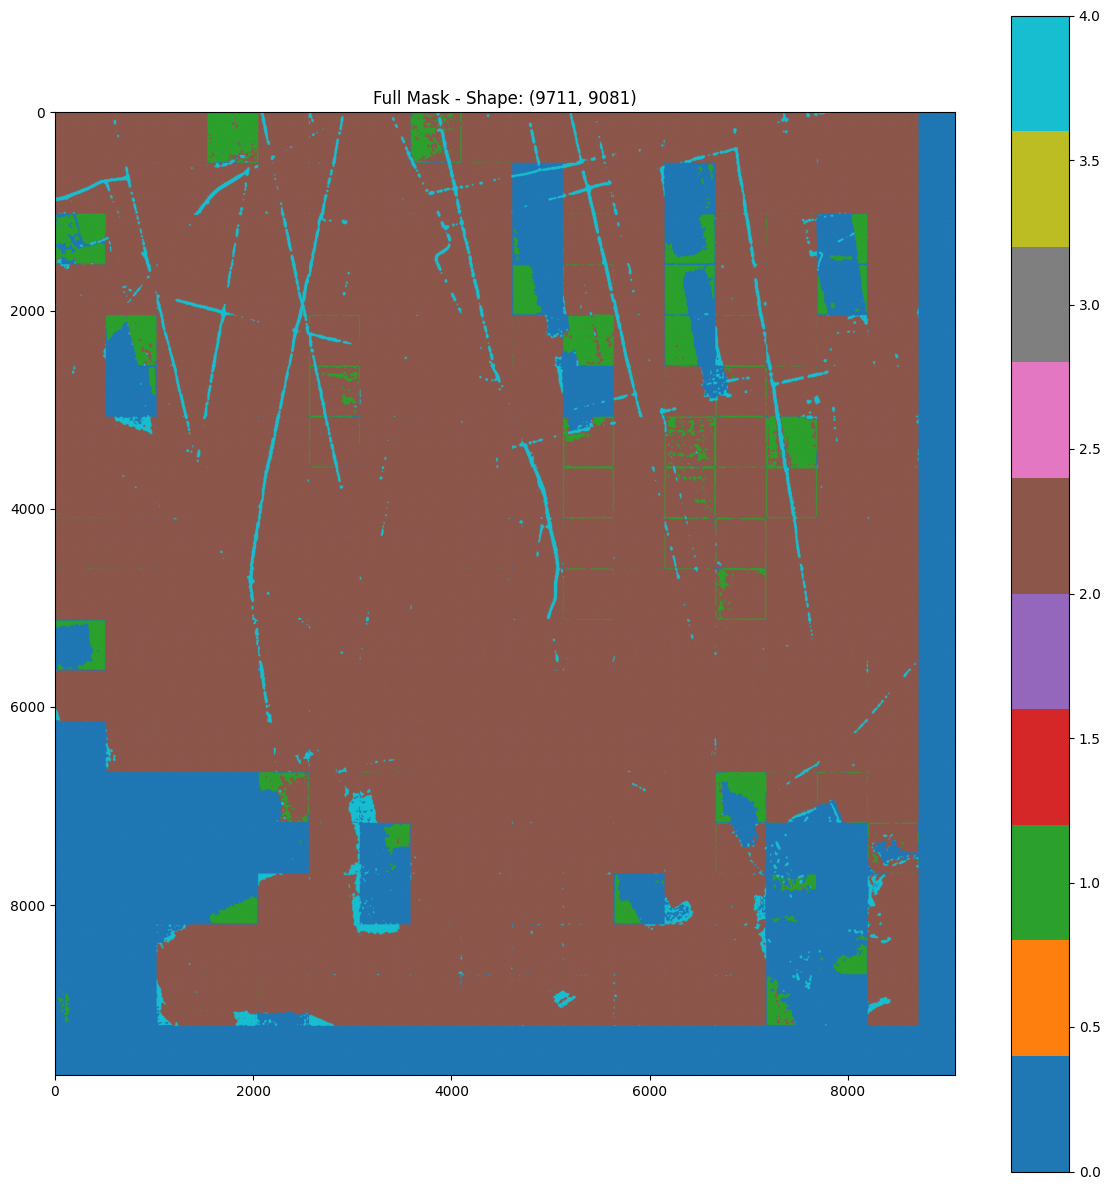

Classes in full mask: [0 1 2 4]


In [112]:
# Load and display the full reconstructed mask
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the full mask
mask_path = "mal_workspace/04_reconstructed/final_landcover_corrected.tif"
full_mask = np.array(Image.open(mask_path))

# Display
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(full_mask, cmap='tab10', vmin=0, vmax=4)
ax.set_title(f'Full Mask - Shape: {full_mask.shape}')
plt.colorbar(ax.imshow(full_mask, cmap='tab10', vmin=0, vmax=4), ax=ax)
plt.tight_layout()
plt.show()

print(f"Classes in full mask: {np.unique(full_mask)}")

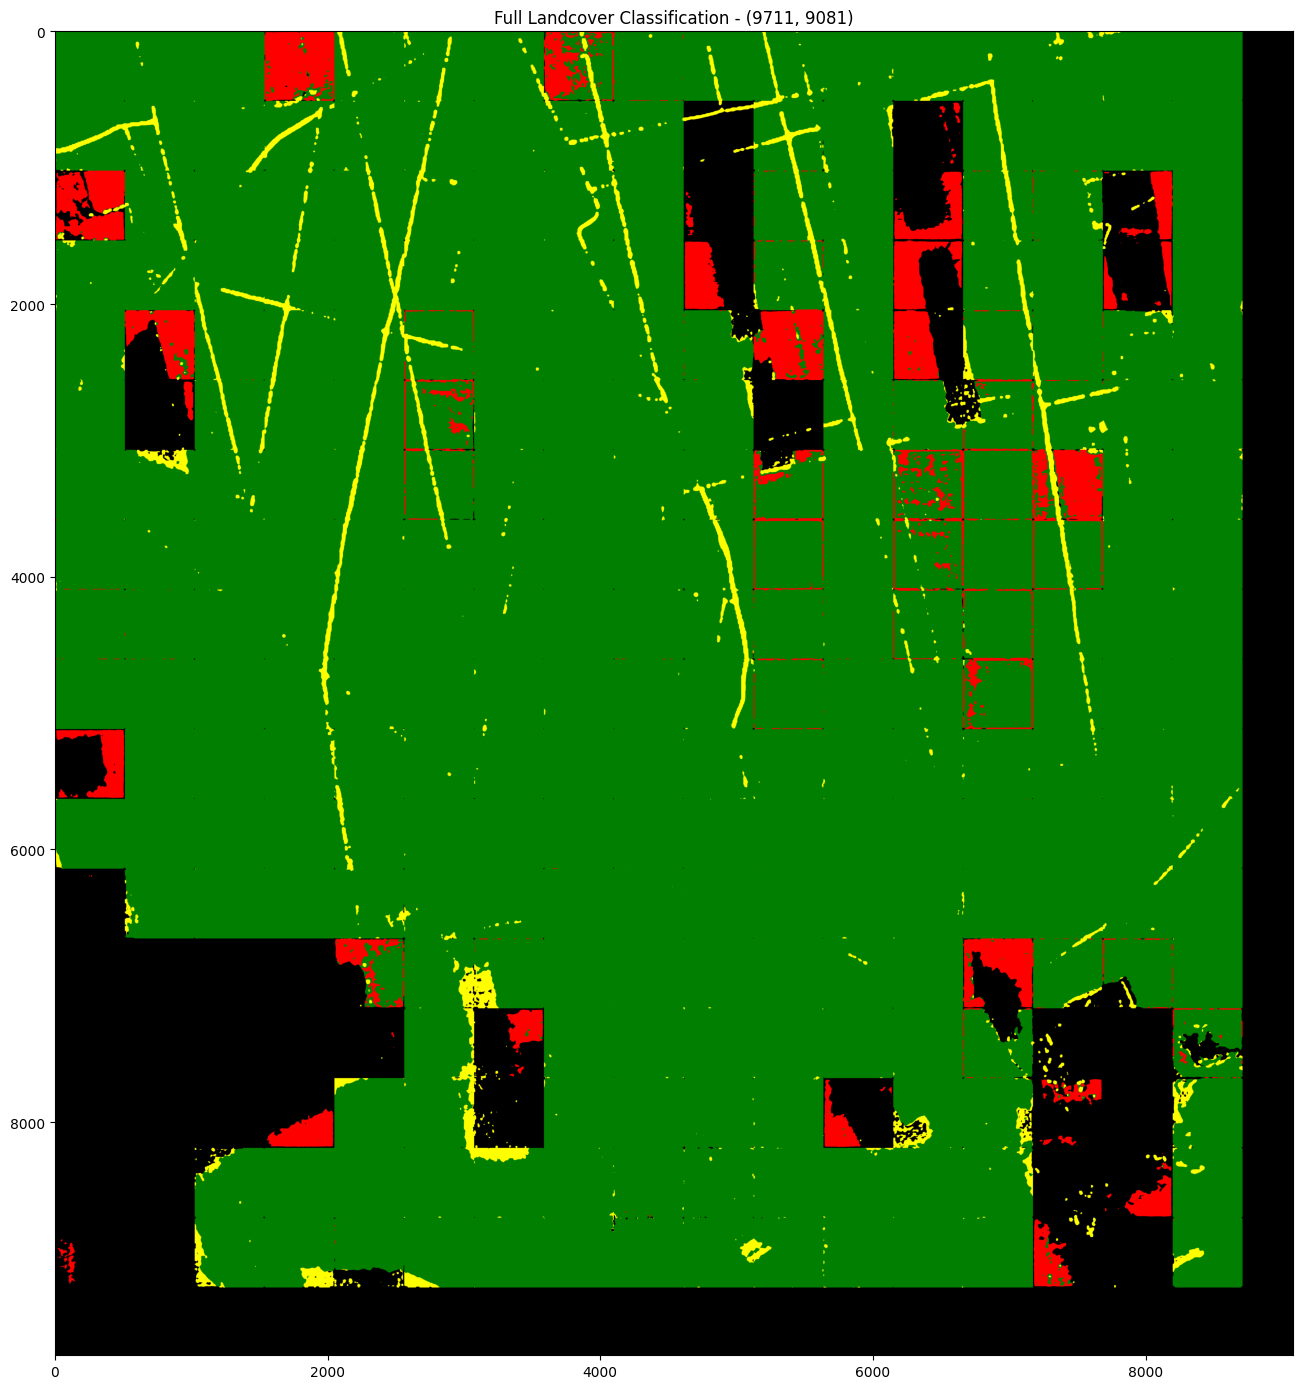

In [113]:
# With proper class colors
class_colors = {
    0: [0.0, 0.0, 0.0],       # background - black
    1: [1.0, 0.0, 0.0],       # building - red
    2: [0.0, 0.5, 0.0],       # woodland - green
    3: [0.0, 0.0, 1.0],       # water - blue
    4: [1.0, 1.0, 0.0],       # road - yellow
}

mask_rgb = np.zeros((*full_mask.shape, 3))
for class_id, color in class_colors.items():
    mask_rgb[full_mask == class_id] = color

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(mask_rgb)
ax.set_title(f'Full Landcover Classification - {full_mask.shape}')
plt.tight_layout()
plt.show()

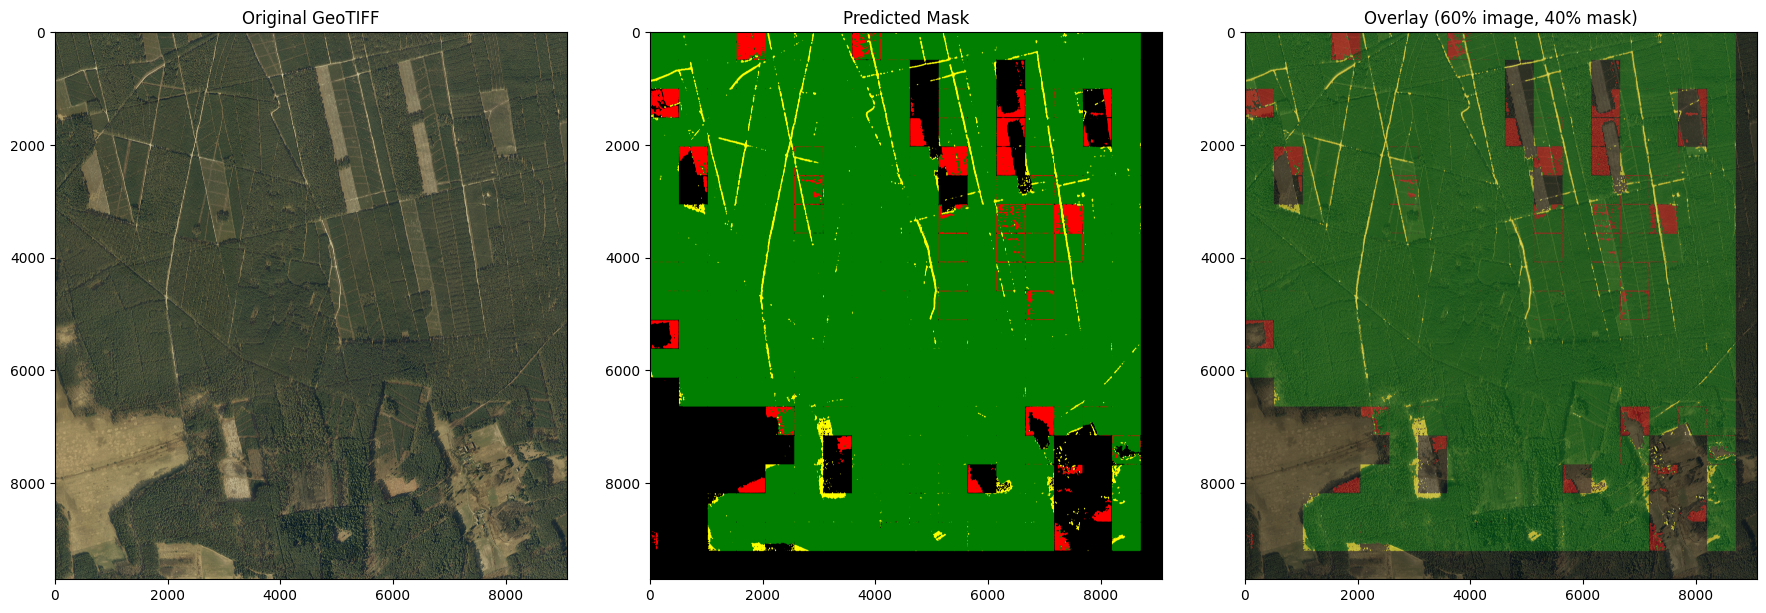

In [114]:
# Load original and mask
original = np.array(Image.open("cvat_test/images/M-33-7-A-d-2-3.tif"))
full_mask = np.array(Image.open(mask_path))

# Create RGB mask
mask_rgb = np.zeros((*full_mask.shape, 3))
for class_id, color in class_colors.items():
    mask_rgb[full_mask == class_id] = color

# Blend
overlay = 0.6 * (original / 255.0) + 0.4 * mask_rgb

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(original)
axes[0].set_title('Original GeoTIFF')
axes[1].imshow(mask_rgb)
axes[1].set_title('Predicted Mask')
axes[2].imshow(overlay)
axes[2].set_title('Overlay (60% image, 40% mask)')
plt.tight_layout()
plt.show()